# Binary Image Classification: Galaxy vs Star
This notebook trains a CNN to classify images as either galaxies or stars using **PyTorch**.

## 1. Import Libraries

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import time

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Common parameters
img_height = 64
img_width = 64
batch_size = 32
data_dir = "images"

PyTorch version: 2.7.1+cu118
CUDA available: True
CUDA device count: 1
Using device: cuda


## 2. Load and Prepare Data
Load images from the folder structure. PyTorch will use folder names as labels.

In [2]:
# Define transforms and create datasets
transform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),  # ensure 1-channel input
        transforms.Resize((img_height, img_width)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
    ]
)

# Consider converting images to greyscale in above section

full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = full_dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)

# Train/val/test split (70/15/15)
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Total images: {total_size}")
print(f"Train: {train_size}, Val: {val_size}, Test: {test_size}")

Classes: ['galaxy', 'star']
Total images: 3986
Train: 2790, Val: 597, Test: 599


## 3. Visualize Sample Images

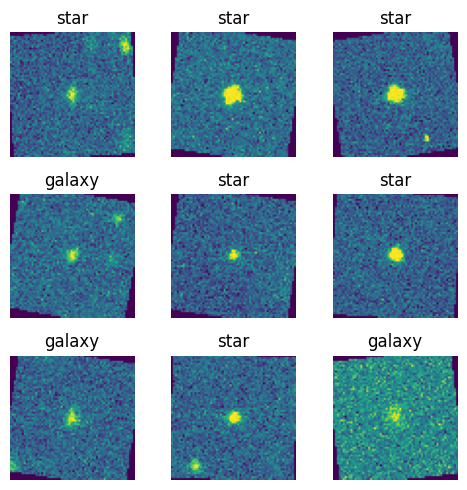

In [3]:
# Display 9 sample images
plt.figure(figsize=(5, 5))
# Take one batch from the training loader
images, labels = next(iter(train_loader))
for i in range(min(9, images.size(0))):
    ax = plt.subplot(3, 3, i + 1)
    img = images[i].permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(class_names[labels[i].item()])
    plt.axis("off")
plt.tight_layout()
plt.show()

## 4. Make CNN

In [4]:
# Define the CNN model in PyTorch
embedding_count = 8

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(  # Consider only input layer for grayscale
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 3 -> 1
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Dropout(0.5),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, embedding_count),  # <-- embedding layer
            nn.ReLU(),
            nn.Linear(embedding_count, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

    def embed(self, x):
        """Return 128‑dim feature embedding for each image."""
        x = self.features(x)
        x = self.classifier[0](x)  # Flatten
        x = self.classifier[1](x)  # Linear(…, embedding_count)
        x = self.classifier[2](x)  # ReLU
        return x

model = SimpleCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print(model)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.5, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=8, bias=True)
    (2): ReLU()
    (3): Linear(in_features=8, out_features=2, bias=True)
  )
)


## 5. Train the model

In [ ]:
epochs = 20
train_losses = []
train_accuracies = []
val_accuracies = []
val_f1_scores = []
epoch_times = []

for epoch in range(epochs):
    epoch_start = time.time()

    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total if total > 0 else 0
    train_acc = running_correct / total if total > 0 else 0

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    val_preds = []
    val_labels_all = []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            val_preds.extend(preds.cpu().numpy().tolist())
            val_labels_all.extend(labels.cpu().numpy().tolist())
    val_acc = val_correct / val_total if val_total > 0 else 0
    if val_total > 0:
        val_f1 = f1_score(val_labels_all, val_preds, average="binary")
    else:
        val_f1 = 0.0

    epoch_time = time.time() - epoch_start
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    val_f1_scores.append(val_f1)
    epoch_times.append(epoch_time)

    print(
        f"Epoch {epoch+1}/{epochs} - ",
        f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, ",
        f"Val acc: {val_acc:.4f}, Val F1: {val_f1:.4f}, Time: {epoch_time:.2f}s"
    )

total_training_time = sum(epoch_times)
print(f"Total training time: {total_training_time:.2f} seconds")

## 6. Collect embeddings

In [ ]:
import numpy as np

def collect_embeddings(dataloader):
    model.eval()
    all_embeds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            embeds = model.embed(images)  # [batch, 128]
            all_embeds.append(embeds.cpu().numpy())
            all_labels.append(labels.numpy())
    return np.concatenate(all_embeds), np.concatenate(all_labels)

## 7. Visualize embedding

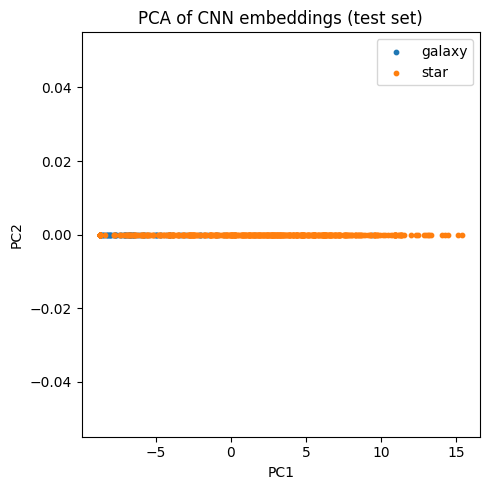

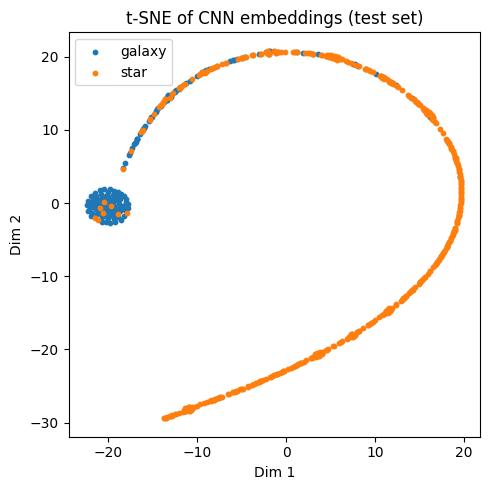

In [ ]:
# 7. Visualize embedding
# Visualize embeddings with PCA / t-SNE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

embeds, labels = collect_embeddings(test_loader)

# PCA
pca = PCA(n_components=2)
embeds_pca = pca.fit_transform(embeds)

# t-SNE
tsne = TSNE(n_components=2, init="random", learning_rate="auto")
embeds_tsne = tsne.fit_transform(embeds)

# --- PCA plot ---
plt.figure(figsize=(5, 5))
for c in np.unique(labels):
    mask = labels == c
    plt.scatter(embeds_pca[mask, 0], embeds_pca[mask, 1], s=10, label=class_names[c])
plt.legend()
plt.title("PCA of CNN embeddings (test set)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

# --- t-SNE plot ---
plt.figure(figsize=(5, 5))
for c in np.unique(labels):
    mask = labels == c
    plt.scatter(embeds_tsne[mask, 0], embeds_tsne[mask, 1], s=10, label=class_names[c])
plt.legend()
plt.title("t-SNE of CNN embeddings (test set)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.tight_layout()
plt.show()

## 8. Linear probe

In [ ]:
# To test quality of embedding

# 8. Linear probe with logistic regression on CNN embeddings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Collect embeddings for each split
X_train, y_train = collect_embeddings(train_loader)
X_val,   y_val   = collect_embeddings(val_loader)
X_test,  y_test  = collect_embeddings(test_loader)

# Logistic regression = linear probe
probe = LogisticRegression(max_iter=1000)
probe.fit(X_train, y_train)

# Evaluate
for name, X, y in [("Train", X_train, y_train),
                   ("Val",   X_val,   y_val),
                   ("Test",  X_test,  y_test)]:
    y_pred = probe.predict(X)
    acc = accuracy_score(y, y_pred)
    f1  = f1_score(y, y_pred, average="binary")
    print(f"{name}  -  acc: {acc:.4f}, f1: {f1:.4f}")

Train  -  acc: 0.8953, f1: 0.9318
Val  -  acc: 0.8844, f1: 0.9224
Test  -  acc: 0.8898, f1: 0.9267


## 9. Encoding and Ansatz

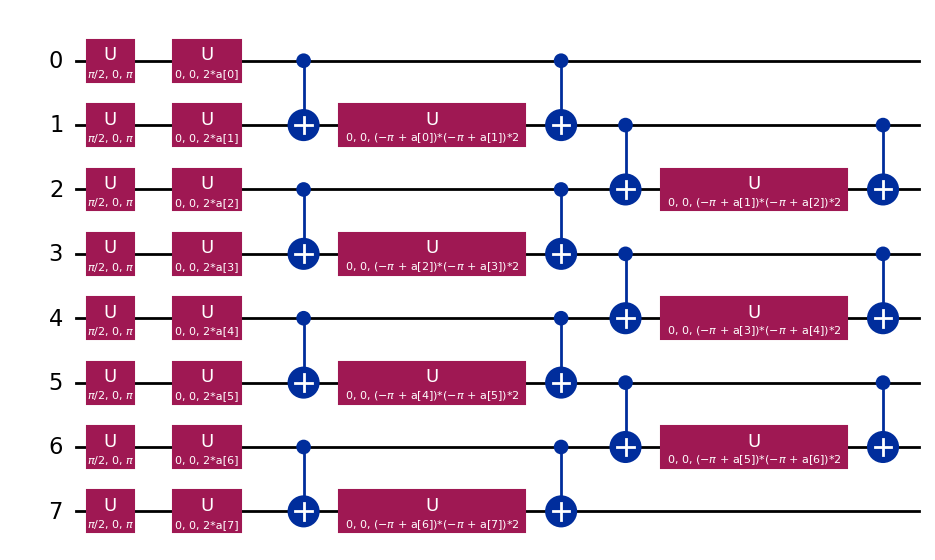

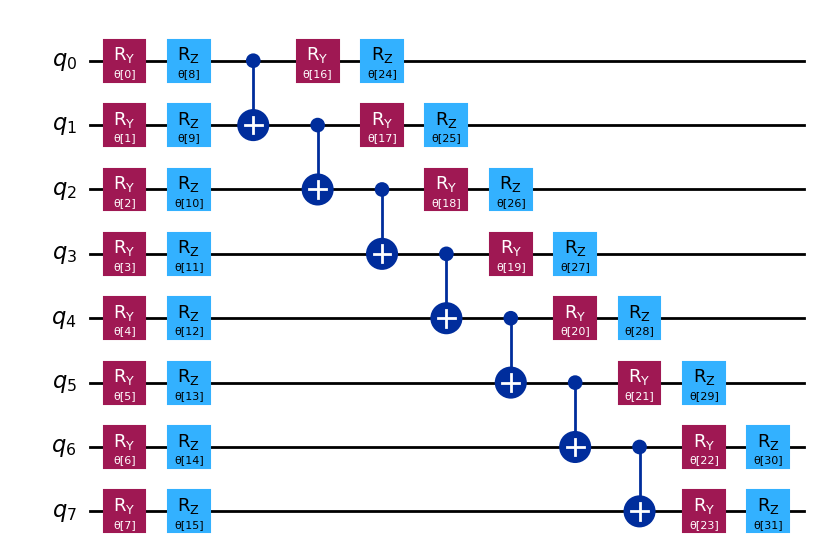

In [ ]:
from qiskit.circuit.library import z_feature_map
from qiskit.circuit.library import zz_feature_map
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import efficient_su2
 
# One qubit per data feature
num_qubits = embedding_count

# ZZ data encoding
# parameter_prefix="a" keeps the same parameter ordering convention
feature_map = zz_feature_map(
    feature_dimension=num_qubits,
    reps=1,                 # you can change depth
    entanglement="linear",  # or "full", "pairwise", etc.
    parameter_prefix="a",
)
fig = feature_map.decompose(reps=1).draw("mpl", scale=1)
display(fig)

# Use EfficientSU2 as the variational ansatz
qnn_circuit = efficient_su2(
    num_qubits=num_qubits,
    reps=1,                 # increase for deeper ansatz
    entanglement="linear",  # or "full", "circular", etc.
)
    
# Draw the circuit
qnn_circuit.draw("mpl")

## 10. Combine

29
2+ qubit depth (combined): 16


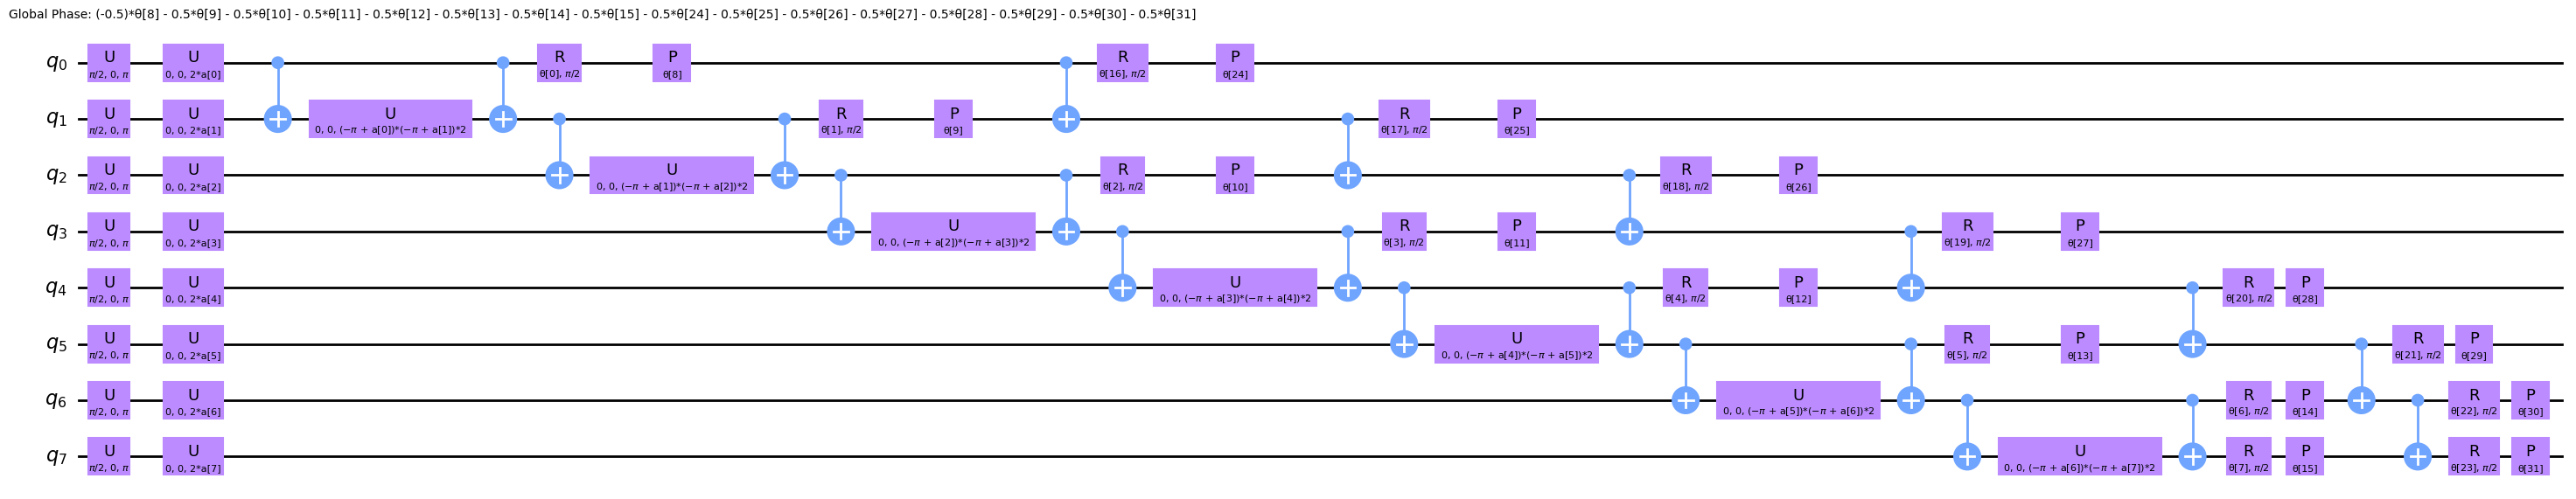

In [10]:
# QNN ansatz
ansatz = qnn_circuit
 
# Combine the feature map with the ansatz
full_circuit = QuantumCircuit(num_qubits)
full_circuit.compose(feature_map, range(num_qubits), inplace=True)
full_circuit.compose(ansatz, range(num_qubits), inplace=True)

# Check the combined circuit depth, and the two-qubit gate depth
print(full_circuit.decompose().depth())
print(
    f"2+ qubit depth (combined): "
    f"{full_circuit.decompose().depth(lambda instr: len(instr.qubits) > 1)}"
)

# Display the circuit
full_circuit.decompose().draw("mpl", style="clifford", fold=-1)

## 11. End-to-end training

In [ ]:
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient

observable = SparsePauliOp.from_list([("Z" * (num_qubits), 1)])

# Quantum estimator (simulator for training)
q_estimator = StatevectorEstimator()

# Explicit gradient for the estimator
estimator_gradient = ParamShiftEstimatorGradient(q_estimator)

# Split parameters: inputs = feature map params, weights = ansatz params
input_params = list(feature_map.parameters)
weight_params = list(ansatz.parameters)

qnn = EstimatorQNN(
    circuit=full_circuit,
    observables=observable,
    estimator=q_estimator,        # <- use your estimator
    gradient=estimator_gradient,
    input_params=input_params,
    weight_params=weight_params,
)

# Turn QNN into a PyTorch layer
quantum_layer = TorchConnector(qnn)

class HybridCQModel(nn.Module):
    def __init__(self, cnn):
        super().__init__()
        self.cnn = cnn          # your SimpleCNN
        self.quantum = quantum_layer

    def forward(self, x):
        # CNN -> embedding (float32)
        z = self.cnn.embed(x)          # [batch, embedding_count]
        # TorchConnector expects double precision
        z = z.to(torch.double)         # [batch, embedding_count] (float64)
        out = self.quantum(z)          # [batch, 1] (float64)
        return out.view(-1)            # [batch]
# Hybrid model: reuse already defined CNN "model"
hybrid_model = HybridCQModel(model).to(device)

criterion_hybrid = nn.BCEWithLogitsLoss()
optimizer_hybrid = optim.Adam(hybrid_model.parameters(), lr=1e-3)

epochs_hybrid = 5
hybrid_train_losses = []
hybrid_train_accuracies = []
hybrid_val_accuracies = []

for epoch in range(epochs_hybrid):
    hybrid_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).double()   # logits are double

        optimizer_hybrid.zero_grad()
        logits = hybrid_model(images)         # [batch]
        loss = criterion_hybrid(logits, labels)
        loss.backward()
        optimizer_hybrid.step()

        running_loss += loss.item() * images.size(0)
        preds = (torch.sigmoid(logits) >= 0.5).long()
        correct += (preds == labels.long()).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # validation
    hybrid_model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device).double()
            logits = hybrid_model(images)
            preds = (torch.sigmoid(logits) >= 0.5).long()
            val_correct += (preds == labels.long()).sum().item()
            val_total += labels.size(0)
    val_acc = val_correct / val_total if val_total > 0 else 0.0

    hybrid_train_losses.append(train_loss)
    hybrid_train_accuracies.append(train_acc)
    hybrid_val_accuracies.append(val_acc)

    print(
        f"Epoch {epoch+1}/{epochs_hybrid} - "
        f"loss {train_loss:.4f}, train acc {train_acc:.4f}, val acc {val_acc:.4f}"
    )

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Epoch 1/5 - loss 0.6907, train acc 0.5720, val acc 0.5611
Epoch 2/5 - loss 0.6869, train acc 0.6043, val acc 0.6415
Epoch 3/5 - loss 0.6775, train acc 0.6986, val acc 0.7387
Epoch 4/5 - loss 0.6631, train acc 0.7649, val acc 0.7387
Epoch 5/5 - loss 0.6464, train acc 0.7649, val acc 0.7387


## 12. Test

### Train data

In [31]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report

hybrid_model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        logits = hybrid_model(images)
        preds = (torch.sigmoid(logits) >= 0.5).long().cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.cpu().numpy())

y_train_all = np.concatenate(all_labels)
y_pred_train = np.concatenate(all_preds)

train_acc = accuracy_score(y_train_all, y_pred_train)
train_f1_bin = f1_score(y_train_all, y_pred_train, average="binary")
train_f1_macro = f1_score(y_train_all, y_pred_train, average="macro")
train_f1_w = f1_score(y_train_all, y_pred_train, average="weighted")

print(f"Hybrid TRAIN  -  acc: {train_acc:.4f}, "
      f"f1_binary: {train_f1_bin:.4f}, "
      f"f1_macro: {train_f1_macro:.4f}, "
      f"f1_weighted: {train_f1_w:.4f}")

Hybrid TRAIN  -  acc: 0.7649, f1_binary: 0.8668, f1_macro: 0.4334, f1_weighted: 0.6630


### Test data

In [33]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report

hybrid_model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        logits = hybrid_model(images)
        preds = (torch.sigmoid(logits) >= 0.5).long().cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.cpu().numpy())

y_test_all = np.concatenate(all_labels)
y_pred_test = np.concatenate(all_preds)

test_acc = accuracy_score(y_test_all, y_pred_test)
test_f1_bin = f1_score(y_test_all, y_pred_test, average="binary")
test_f1_macro = f1_score(y_test_all, y_pred_test, average="macro")
test_f1_w = f1_score(y_test_all, y_pred_test, average="weighted")

print(f"Hybrid TEST   -  acc: {test_acc:.4f}, "
      f"f1_binary: {test_f1_bin:.4f}, "
      f"f1_macro: {test_f1_macro:.4f}, "
      f"f1_weighted: {test_f1_w:.4f}")

Hybrid TEST   -  acc: 0.7830, f1_binary: 0.8783, f1_macro: 0.4391, f1_weighted: 0.6877


## 13. Convergence

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(hybrid_train_losses, label="Hybrid train loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

NameError: name 'hybrid_train_losses' is not defined

<Figure size 1200x600 with 0 Axes>